# Simulating Exponential Distributions using Quantum Galton Box

### Overview
This notebook modifies the quantum Galton Box to generate an exponential-like output distribution. This is done by introducing a fixed bias in the coin operation using a controlled RY rotation with a small angle (e.g., π/6). This mimics a higher probability of 'falling' in one direction, leading to a right-skewed distribution similar to the exponential function.

### Goals
- Modify the Galton board logic to induce asymmetry.
- Calibrate coin biases to match the characteristics of an exponential distribution.
- Simulate the noise-free output and compare with a classical exponential distribution for validation.


In [1]:
# Standard libraries imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import os

# Jupyter notebooks magic line command
%matplotlib inline

# Create output directory
output_dir = "../outputs/Derivable3a/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

STEP 1: Create A Biased Galton Box using RY gates

In [2]:
def create_exponential_galton_box(n_layers, theta):
    """
    Construct a quantum circuit for an exponential-like biased Galton box.
    
    Parameters:
        layers (int): Number of RY+CNOT layers.
        theta (float): Angle for RY gates to bias toward '0'.
    
    Returns:
        QuantumCircuit: The quantum Galton box circuit.
    """
    n_qubits = n_layers
    qc = QuantumCircuit(n_qubits, n_qubits)

    # Apply biased "coin flip" rotations to each qubit
    for i in range(n_qubits):
        qc.ry(theta, i)

    # CNOTs simulate the collisions and branching in Galton box
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)

    # Measure all qubits
    qc.barrier()
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

STEP 2: Run the Quantum Circuit to Get the Result of Measurement

In [3]:
def simulate_distribution(qc, shots=2048):
    """
    Execute the quantum circuit and gather measurement counts.
    
    Parameters:
        qc (QuantumCircuit): The quantum Galton box circuit.
        shots (int): Number of runs to sample from circuit.
    
    Returns:
        dict: Raw measurement counts.
    """
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots).result()
    counts = result.get_counts()
    return counts

STEP 3: Overlay Histogram with Ideal Exponential Curve

In [4]:
def plot_with_exponential_overlay(counts, theta, save_path=None):
    """
    Plot the measured distribution and overlay the ideal exponential decay.
    
    Parameters:
        counts (dict): Simulation result (bitstring → counts).
        theta (float): Bias angle used in RY gates.
        title (str): Plot title.
        save_path (str): File name to save the plot image.
    """
    # Convert bitstrings to integers
    int_counts = {int(k, 2): v for k, v in counts.items()}
    max_bin = max(int_counts.keys())
    bins = np.arange(max_bin + 1)
    
    # Normalize histogram values
    total = sum(int_counts.values())
    measured_probs = np.array([int_counts.get(i, 0) / total for i in bins])
    
    # Theoretical exponential distribution
    lambd = np.tan(theta/2)**2  # crude estimate from RY bias
    theoretical = np.exp(-lambd * bins)
    theoretical /= np.sum(theoretical)  # Normalize to match

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(bins, measured_probs, width=0.6, label="Quantum Simulation", alpha=0.6)
    plt.plot(bins, theoretical, 'r--o', label=f"Theoretical Exponential (λ ≈ {lambd:.2f})")
    plt.xlabel("Output (decimal value)")
    plt.ylabel("Probability")
    plt.title(f'Exponential Quantum Walk (Layers={n_layers})')
    plt.legend()
    plt.grid(True)
    
    # # Save and show
    # save_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/exponential_distribution_plot.png"
    # plt.savefig(save_path, dpi=300)
    # plt.show()
    # print(f"[✓] Plot saved to: {save_path}")

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

STEP 4: Run Everything and Display the Outcome

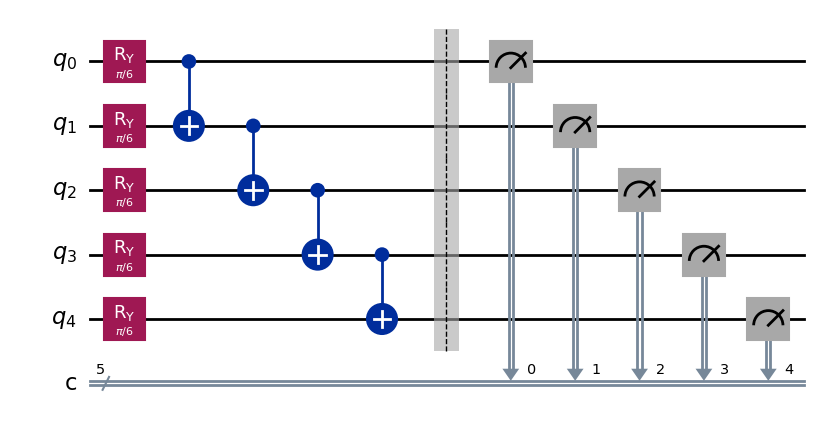

In [5]:
# Build the circuit
n_layers = 5
theta = np.pi / 6  # Bias for exponential shape

qc = create_exponential_galton_box(n_layers=n_layers, theta=theta)

# Save circuit diagram
circuit_path = os.path.join(output_dir, "exponential_galton_box_circuit.png")
circuit_drawer(qc, output='mpl', filename=circuit_path)
    
#Run the simulation
counts = simulate_distribution(qc)

[✓] Plot saved to: ../outputs/Derivable3a/exponential_distribution_plot.png


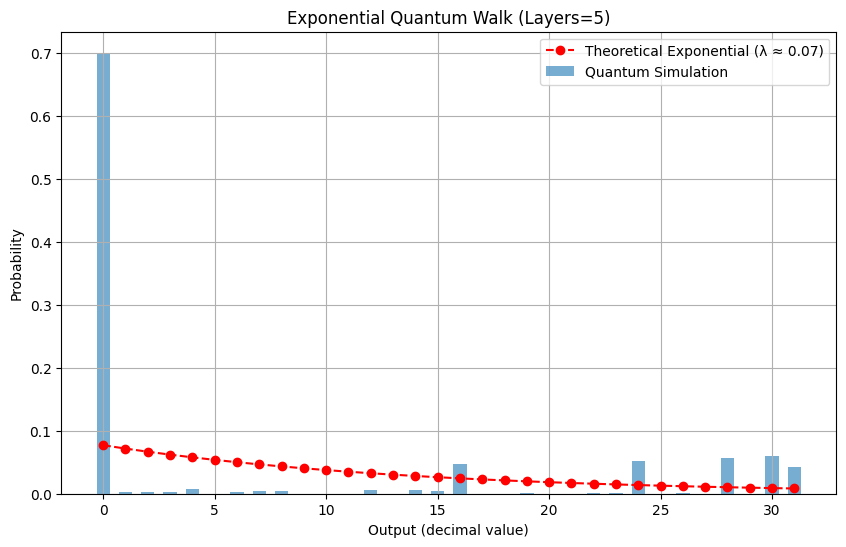

In [6]:
# Save and show the distribution plot
plot_path = os.path.join(output_dir, "exponential_distribution_plot.png")
print(f"[✓] Plot saved to: {plot_path}")

# Exponential plot
plot_with_exponential_overlay(counts, theta, save_path=plot_path)